(sec:rnn)=
# Recurrent Neural Networks

Recurrent neural networks (RNNs) proceed by processing elements of a time
series one at a time.
Typically, at time $t$, a recurrent block will take both the current input $x_t$
and a hidden state $h_{t-1}$ that aims at summarizing the key information from
past inputs $\{x_0, \dots, x_{t-1}\}$, and will output an updated hidden state
$h_{t}$.
There exist various recurrent modules that mostly differ in the way $h_t$ is
computed.

In [1]:
%config InlineBackend.figure_format = 'svg'
%matplotlib inline
import matplotlib.pyplot as plt

plt.ion();

## "Vanilla" RNNs

The basic formulation for a RNN block is as follows:

\begin{equation}
    \forall t, h_t = \text{tanh}(W_h h_{t-1} + W_x x_t + b)
\end{equation}

where $W_h$ is a weight matrix associated to the processing of the previous
hidden state, $W_x$ is another weight matrix associated to the processing of
the current input and $b$ is a bias term.

Note here that $W_h$, $W_x$ and $b$ are not indexed by $t$, which means that
they are **shared across all timestamps**.

An important limitation of this formula is that it easily fails at capturing
long-term dependencies.
To better understand why, one should remind that the parameters of these
networks are optimized through stochastic gradient descent algorithms.

To simplify notations, let us consider a simplified case in which
$h_t$ and $x_t$ are both scalar values, and let us have a look at what the
actual gradient of the output $h_t$ is, with
respect to $W_h$ (which is then also a scalar):

\begin{equation}
    \nabla_{W_h}(h_t) = \text{tanh}^\prime(o_t) \cdot \frac{\partial o_t}{\partial W_h}
\end{equation}

where $o_t = W_h h_{t-1} + W_x x_t + b$, hence:

\begin{equation}
    \frac{\partial o_t}{\partial W_h} = h_{t-1} + W_h \cdot \frac{\partial h_{t-1}}{\partial W_h} \, .
\end{equation}

Here, the form of $\frac{\partial h_{t-1}}{\partial W_h}$ will be similar to
that of $\nabla_{W_h}(h_t)$ above, and, in the end, one gets:

\begin{eqnarray}
    \nabla_{W_h}(h_t) &=& \text{tanh}^\prime(o_t) \cdot
        \left[
            h_{t-1} + W_h \cdot \frac{\partial h_{t-1}}{\partial W_h}
        \right] \\
        &=& \text{tanh}^\prime(o_t) \cdot
           \left[
               h_{t-1} + W_h \cdot \text{tanh}^\prime(o_{t-1}) \cdot
               \left[
                   h_{t-2} + W_h \cdot \left[ \dots \right]
               \right]
           \right] \\
          &=& h_{t-1} \text{tanh}^\prime(o_t) + h_{t-2} W_h \text{tanh}^\prime(o_t) \text{tanh}^\prime(o_{t-1}) + \dots \\
         &=& \sum_{t^\prime = 1}^{t-1} h_{t^\prime} \left[ W_h^{t-t^\prime-1} \text{tanh}^\prime(o_{t^\prime+1}) \cdot \cdots \cdot  \text{tanh}^\prime(o_{t}) \right]
\end{eqnarray}

In other words, the influence of $h_{t^\prime}$ will be mitigated by a factor
$W_h^{t-t^\prime-1} \text{tanh}^\prime(o_{t^\prime+1}) \cdot \cdots \cdot  \text{tanh}^\prime(o_{t})$.

Now recall what the tanh function and its derivative look like:

2022-10-04 21:02:46.478752: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-04 21:02:46.625905: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-04 21:02:46.625924: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-04 21:02:46.657711: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2022-10-04 21:02:47.347784: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-04 21:02:47.347866: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-10-04 21:02:47.347874: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


2022-10-04 21:02:48.203828: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-04 21:02:48.203869: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-04 21:02:48.203887: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fv-az121-601): /proc/driver/nvidia/version does not exist
2022-10-04 21:02:48.204177: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


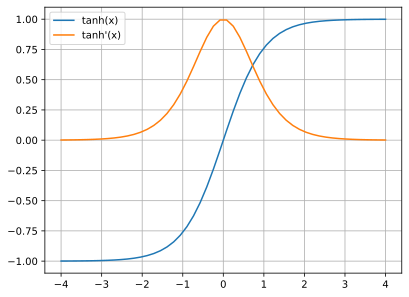

In [2]:
import tensorflow as tf

def tanh(x):
    return 2. / (1. + tf.exp(-2 * x)) - 1.

x = tf.Variable(tf.linspace(-4, 4, 50))
with tf.GradientTape() as tape:
    tan_x = tanh(x)
grad_tanh_x = tape.gradient(tan_x, x)

plt.figure()
plt.plot(x.numpy(), tan_x.numpy(), label='tanh(x)')
plt.plot(x.numpy(), grad_tanh_x, label='tanh\'(x)')
plt.legend()
plt.grid('on');

One can see how quickly gradients gets close to 0 for inputs larger
(in absolute value) than 2, and having multiple such terms in a
computation chain will likely make the corresponding terms vanish.

In other words, the gradient of the hidden state at time $t$ will only be
influenced by a few of its predecessors $\{h_{t-1}, h_{t-2}, \dots\}$ and
long-term dependencies will be ignored when updating model parameters through
gradient descent.
This is an occurrence of a more general phenomenon known as the
**vanishing gradient** effect.

## Long Short-Term Memory

The Long Short-Term Memory (LSTM, {cite:p}`hochreiter1997long`) blocks have
been designed as an alternative
recurrent block that aims at mitigating this vanishing gradient effect through
the use of gates that explicitly encode pieces of information that should
(resp. should not) be kept in computations.

```{admonition} Gates in neural networks
:class: tip

In the neural networks terminology, a gate $g \in [0, 1]^d$ is a vector that is
used to filter out information from an incoming feature vector
$v \in \mathbb{R}^d$ such that the result of applying the gate is: $g \odot v$
where $\odot$ is the element-wise product.
The gate $g$ will hence tend to remove part of the features in $v$
(those corresponding to very low values in $g$).
```

In these blocks, an extra state is used, referred to as the cell state $C_t$.
This state is computed as:

\begin{equation}
    C_t = f_t \odot C_{t-1} + i_t \odot \tilde{C}_t
\end{equation}

where $f_t$ is the forget gate (which pushes the network to forget about
useless parts of the past cell state),
$i_t$ is the input gate and $\tilde{C}_t$ is
an updated version of the cell state (which, in turn, can be partly censored
by the input gate).

Let us delay for now the details about how these 3 terms are computed, and
rather focus on how the formula above is significantly different from the
update rule of the hidden state in vanilla RNNs.
Indeed, in this case, if the network learns so (through $f_t$), the
full information from the previous cell state $C_{t-1}$ can be recovered,
which would allow gradients to flow through time (and not vanish anymore).

Then, the link between the cell and hidden states is:

\begin{equation}
    h_t = o_t \odot \text{tanh}(C_{t}) \, .
\end{equation}

In words, the hidden state is the tanh-transformed version of the cell state,
further censored by an output gate $o_t$.

All gates used in the formulas above are defined similarly:

\begin{eqnarray}
    f_t &=& \sigma ( W_f \cdot [h_{t-1}, x_t] + b_f) \\
    i_t &=& \sigma ( W_i \cdot [h_{t-1}, x_t] + b_i) \\
    o_t &=& \sigma ( W_o \cdot [h_{t-1}, x_t] + b_o)
\end{eqnarray}

where $\sigma$ is the sigmoid activation function
(which has values in $[0, 1]$) and $[h_{t-1}, x_t]$ is
the concatenation of $h_{t-1}$ and $x_t$ features.

Finally, the updated cell state $\tilde{C}_t$ is computed as:

\begin{equation}
    \tilde{C}_t = \text{tanh}(W_C \cdot [h_{t-1}, x_t] + b_C) \, .
\end{equation}

Many variants over these LSTM blocks exist in the literature that still rely
on the same basic principles.

## Gated Recurrent Unit

A slightly different parametrization of a recurrent block is used in the
so-called Gatted Recurrent Unit (GRU, {cite:p}`cho2014properties`).

GRUs also rely on the use of gates to (adaptively) let information flow
through time.
A first significant difference between GRUs and LSTMs, though, is that GRUs
do not resort to the use of a cell state.
Instead, the update rule for the hidden state is:

\begin{equation}
    h_t = (1 - z_t) \odot h_{t-1} + z_t \odot \tilde{h}_t
\end{equation}

where $z_t$ is a gate that balances (per feature) the amount of information
that is kept from the previous hidden state with the amount of information
that should be updated using the new candidate hidden state $\tilde{h}_t$,
computed as:

\begin{equation}
    \tilde{h}_t = \text{tanh}(W \cdot [r_t \odot h_{t-1}, x_t] + b) \, ,
\end{equation}

where $r_t$ is an extra gate that can hide part of the previous hidden state.

Formulas for gates $z_t$ and $r_t$ are similar to those provided for $f_t$,
$i_t$ and $o_t$ in the case of LSTMs.

A study of the ability of these variants of recurrent networks to learn
long-term dependencies is provided
[in this online publication](https://distill.pub/2019/memorization-in-rnns/).

## Conclusion

In this chapter, we have reviewed neural network architectures that are
used to learn from time series datasets.
Because of time constraints, we have not tackled attention-based models
in this course.
We have presented convolutional models that aim at extracting discriminative
local shapes in the series and recurrent models that rather leverage the
notion of sequence.
Concerning the latter, variants that aim at facing the vanishing gradient
effect have been introduced.
Note that recurrent models are known to require more training data than
their convolutional counterparts in order to
learn meaningful representations.

## References

```{bibliography}
:filter: docname in docnames
```